In [1]:
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb
import os
import pandas as pd
from scipy import sparse
from sklearn import metrics, model_selection
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from classif import PartSelector
import re

## Data Prep
1. The `nature` and `cost_center` columns are converted from float into "category" dtype.
2. Input features (rfc, name, desc) are converted into string dtype.
3. We create a subset dataframe with the columns we care about. 3 features and 2 targets

In [4]:
df = pd.read_csv('./data/data-sample-invoices.csv')

# Convert codes as floats into category types
df['nature'] = df['nature'].astype('Int64')
df['nature'] = df['nature'].astype('category')

df['cost_center'] = df['cost_center'].astype('Int64')
df['cost_center'] = df['cost_center'].astype('category')

In [5]:
# Coerce input features to string
df['counterparty_rfc'] = df['counterparty_rfc'].astype('str')
df['counterparty_name'] = df['counterparty_name'].astype('str')
df['descriptions'] = df['descriptions'].astype('str')

In [6]:
# Subset the working dataset columns: features + targets

feature_names = ['counterparty_name', 'counterparty_rfc', 'descriptions']
target_names = ['nature', 'cost_center']

data = df.copy()[feature_names + target_names]

In [7]:
data.dtypes

counterparty_name      object
counterparty_rfc       object
descriptions           object
nature               category
cost_center          category
dtype: object

### Regularize text: Create an `all_text` column for vectorization
1. Restore accented characters in html encoding. 
2. Convert target NA values (NaN) into empty strings.
3. Concatenate input features into an `all_text` col, removing newlines.

In [8]:
def _convertAccented(text, pattobj):
        '''
        Restore characters from lowercase text, eg. "&oacute;" -> "ó"
        '''
        accented = {
            'a':'á',
            'e':'é',
            'i':'í',
            'o': 'ó',
            'u':'ú'
        }

        def accentRepl(matchobj):
            letter = matchobj.group(1)
            return accented[letter]

        return pattobj.sub(accentRepl, text)

In [9]:
patt = r'&([aeiou])acute;'  # vowel is captured by group 1
accent_rgx = re.compile(patt)      # compiled beforehand for performance
    
def f(row):
    '''
    Creates a value for the column all_text with the concatenation of string values, 
    emmpty strings if nan.
    '''
    notna = row.notna()
    
    name = row['counterparty_name'] if notna['counterparty_name'] else ''
    rfc = row['counterparty_rfc'] if notna['counterparty_rfc'] else ''
    descriptions = row['descriptions'] if notna['descriptions'] else ''
    
    all_text = ' '.join([
                    name,
                    rfc,
                    descriptions,
                ]).replace('\n', ' ')
    
    # Normalize to lowercase and remove html syntax characters
    all_text = _convertAccented(all_text.lower(), accent_rgx)
    return all_text

In [10]:
data['all_text'] = data.apply(lambda x: f(x), axis=1)

#### Also encode class labels ('61318' -> 1) for our classifier
- add them into separate code columns

In [11]:
# Create columns for the targets' category encoding.

data['nature_code'] = data['nature'].cat.codes
data['cost_center_code'] = data['cost_center'].cat.codes

In [12]:
data.columns

Index(['counterparty_name', 'counterparty_rfc', 'descriptions', 'nature',
       'cost_center', 'all_text', 'nature_code', 'cost_center_code'],
      dtype='object')

Before we feed into a model, we must:
1. Remove rows having NA depending on target
2. Split into training and validation sets

We then run the model, finally we evaluate.

### Split into nature and cost_center data, removing NA target values

In [13]:
# TARGET nature
na_nature = data['nature'].isna().sum()
print("Total", len(data))
print(na_nature)
print("total - NA = ", len(data) - na_nature)

# TARGET nature
nature_data = data.dropna(axis=0, subset=['nature'], how='any', inplace=False)
print("After dropna:", len(nature_data))

Total 26040
9844
total - NA =  16196
After dropna: 16196


In [14]:
# TARGET cost_center
na_cost = data['cost_center'].isna().sum()
print("Total", len(data))
print(na_cost)
print("total - NA = ", len(data) - na_cost)

# TARGET cost
cost_data = data.dropna(axis=0, subset=['cost_center'], how='any', inplace=False)
print("After dropna:", len(cost_data))

Total 26040
409
total - NA =  25631
After dropna: 25631


In [15]:
len(set(nature_data['nature'])) # how many nature classes?

171

In [16]:
len(set(cost_data['cost_center'])) # how many nature classes?

273

### Vectorization: 
- We use hashing vectorizer so we don't need in-memory dictionary or vocabulary
- Number of features is fixed

In [17]:
# NATURE
vect = HashingVectorizer(n_features=262144, ngram_range=(1, 2),
                        binary=True, strip_accents='ascii') # removes accented chars.

X = nature_data['all_text']  # name, rfc, descriptions
vectorized_X = vect.transform(X)

# Labels vector
y = np.array(nature_data['nature_code'])

In [18]:
# COST CENTER
vect_c = HashingVectorizer(n_features=262144, ngram_range=(1, 2),
                        binary=True, strip_accents='ascii') 

X_c = cost_data['all_text']  # name, rfc, descriptions
vectorized_X_c = vect.transform(X_c)

# Labels vector
y_c = np.array(cost_data['cost_center_code'])

#### Visualize the data

c:\users\eric\documents\listo-classifier\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


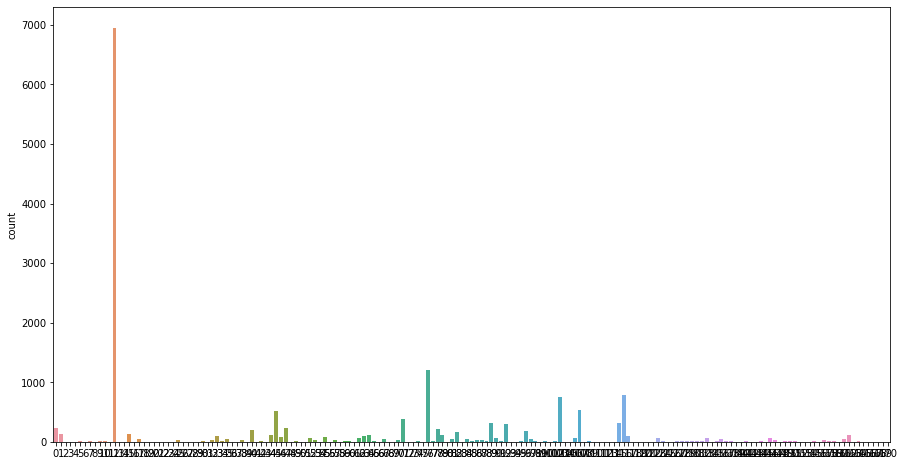

In [81]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,8
_ = sns.countplot(y)

c:\users\eric\documents\listo-classifier\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


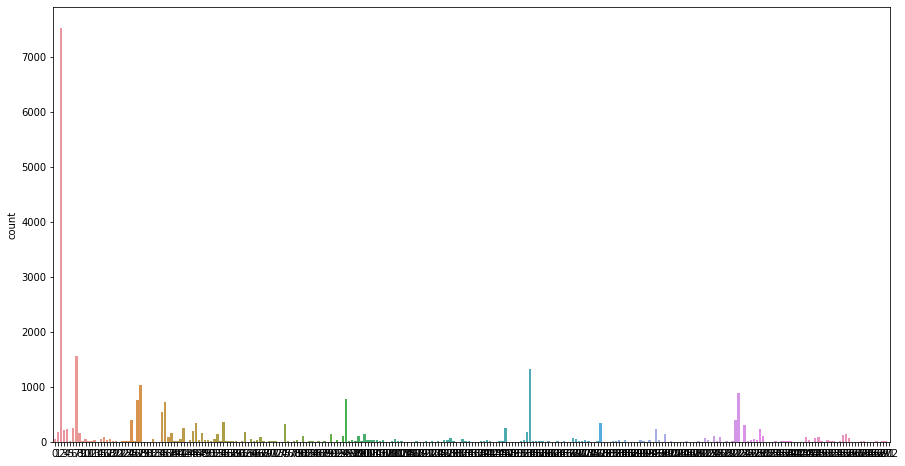

In [54]:
_ = sns.countplot(y_c)

In [21]:
from collections import Counter
def most_frequent(List):
    occurence_count = Counter(List)
    print("Most common:", occurence_count.most_common(1)[0][0])
    return occurence_count

print("Nature")
nature = most_frequent(y)
print("Cost")
cost_center = most_frequent(y_c)

Nature
Most common: 12
Cost
Most common: 2


In [26]:
nature[12]

6954

In [27]:
cost_center[2]

7538

In [29]:
6954/len(y)

0.4293652753766362

### Split the data into Training and Testing

In [19]:
# TARGET nature
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                                                    vectorized_X, 
                                                                    y, 
                                                                    test_size=0.3,   # like curr implementation
                                                                    random_state=0
                                                                    )

In [20]:
# TARGET cost_center
X_train_c, X_test_c, y_train_c, y_test_c = model_selection.train_test_split(
                                                                    vectorized_X_c, 
                                                                    y_c, 
                                                                    test_size=0.3,   # like curr implementation
                                                                    random_state=0
                                                                    )

## XGB classifier

### Instantiate `DMatrix` 

In [85]:
# Sanity checks
X_train.shape[0]==len(y_train) and  X_test.shape[0]==len(y_test) \
and X_train_c.shape[0]==len(y_train_c) and  X_test_c.shape[0]==len(y_test_c)

True

In [87]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest =  xgb.DMatrix(X_test, label=y_test)

In [86]:
dtrain_c = xgb.DMatrix(X_train_c, label=y_train_c)
dtest_c =  xgb.DMatrix(X_test_c, label=y_test_c)

#### Init a boosted classifier

[Softmax!](https://en.wikipedia.org/wiki/Softmax_function)

In [29]:
# we need to set the number of classes in num_class.
NUM_CLASSES = len(set(y))

params = {
    'max_depth':6,  # the deeper the more complex. default=6. TOVARY
    'eta': 1, # step size shrinkage in every update to prevent overfitting. default=0.3 TOVARY
    'objective': 'multi:softmax',  # alternatively, softprob
    'num_class': NUM_CLASSES,
    'eval_metric': 'merror'
}

watchlist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 1 # number of boosting rounds. 1 seems to be very good

In [30]:
bst = xgb.train(params, dtrain, num_round, watchlist)

[0]	eval-merror:0.33032	train-merror:0.31534


In [163]:
pred_y = bst.predict(dtest)
true_y = dtest.get_label()

# both are float32 arrays

In [164]:
results = pd.DataFrame({'pred':pred_y, 'true':true_y}, dtype='int64')

In [165]:
results.head(20)

,pred,true
0,76,138
1,92,115
2,12,116
3,107,107
4,12,12
5,12,12
6,12,12
7,71,47
8,89,96
9,107,107


In [166]:
d = len(set(true_y).difference(set(pred_y)))

In [167]:
d_ = len(set(results['true']).difference(set(results['pred'])))

In [168]:
e = (sum(1 for i in range(len(pred_y)) if pred_y[i] != true_y[i]) /
       float(len(pred_y)))
a = 1 - e
print('error=%f accuracy=%f' % (e, a)
      )

error=0.330315 accuracy=0.669685


# Second try 
From github repo (gabrielziegler3/xgboost-multiclass-multilabel)

# Decision Tree Classifiers (`sklearn`)
We attempt three more classifiers:
1. Random Forest
2. Decision Tree
3. AdaBoost

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Sub sample size is controlled by the `max_samples` parameter + `bootstrap=True`

In [32]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Random forest

In [34]:
# Random forest with 10 trees and one feature per split.
# each individual tree is at most 5 splits deep
rf_nature = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

rf_nature.fit(X_train, y_train)
score = rf_nature.score(X_test, y_test)

print("Random forest (nature) score:", score)  
# its very close to the percentage of majority class.

rf_cost = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf_cost.fit(X_train_c,y_train_c)

score = rf_cost.score(X_test_c, y_test_c)

print("Random forest (cost) score:", score)
# its very close to the percentage of majority class.

Random forest (nature) score: 0.42951224531796667
Random forest (cost) score: 0.294148244473342


### Decision Tree

In [36]:
dt_nature = DecisionTreeClassifier(max_depth=5)

dt_nature.fit(X_train, y_train)
score = dt_nature.score(X_test, y_test)

print("decision tree (nature) score:", score)  

dt_cost = DecisionTreeClassifier(max_depth=5)

dt_cost.fit(X_train_c, y_train_c)
score = dt_cost.score(X_test_c, y_test_c)

print("decision tree (nature) score:", score)  

decision tree (nature) score: 0.5511422103313439
decision tree (nature) score: 0.3781534460338101
